<a href="https://colab.research.google.com/github/SangBeom-Hahn/BOAZ/blob/main/3%EC%9E%A5_%EC%83%9D%EC%9D%BC_%EC%83%9D%EC%84%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 느낀점

1. mnist 같은 잘 가공된 데이터만 하다가 이런 데이터를 내가 만들어서 하려니 많이 어렵더라, 하지만 이런게 다 경험이고 피고 살이다.

2. 배열을 ndarray로 만들어야하는 경우가 은근있다.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
size = 6
shape = size

z_dim = 1 # 크기 1의 잡음 스칼라 

In [ ]:
# 생성자 구현
def build_generator(z_dim):
  model = Sequential()

  model.add(Dense(2, input_dim = z_dim)) # 인풋은 1 다음은 2개의 노드
  model.add(LeakyReLU(alpha = 0.01))
  model.add(Dense(6, activation="sigmoid")) # 2개의 노드 다음은 6개의 노드

  return model

In [ ]:
def build_discriminator(shape):
  model = Sequential()

  model.add(Dense(2, input_dim = shape))
  model.add(LeakyReLU(alpha=0.01))
  model.add(Dense(1, activation="sigmoid"))

  return model

In [ ]:
def build_gan(generator, discriminator):

    model = Sequential()

    # 생성자 -> 판별자로 연결된 모델
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
discriminator = build_discriminator(shape)
discriminator.compile(loss="binary_crossentropy", # 맞다 아니다
                      optimizer=Adam(),
                      metrics=['accuracy'])

generator = build_generator(z_dim)

discriminator.trainable = False # 생성자를 훈련하는 동안 판별자가 훈련되지 않도록 동결 
# -> 참 신기한게  train 함수에 생성자, 판별자 생성을 넣은 것도 아니고 .trainable = False를 밖에서 그냥 한 건데 훈련시 동결이 된대 이게 라이브러리 메소드의 힘이다!!

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
X_train = []

for i in range(10000):
  X = [np.random.uniform(8.8, 9.2), np.random.uniform(8.8, 9.2), np.random.uniform(0.0, 0.2), np.random.uniform(8.8, 9.2), np.random.uniform(0.8, 1.2), np.random.uniform(6.8, 7.2)]
  X_train.append(X)

print(np.array(X_train).shape)
print(np.array(X_train[0]))
print(np.array(X_train[1]))

(10000, 6)
[9.09988916 9.15511895 0.1065889  8.94414759 0.81755263 6.94248344]
[8.93788626 9.16070218 0.02882099 8.86074042 0.84686088 7.09255877]


In [ ]:
losses = [] #이건 그저 손실을 그래프로 그리긴 위한 배열
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    # 10000행의 6열(990917)이 필요, 생성자의 입력이 0~1인 시그모이드인데 훈련데이터는 걍 0~9의 수로 했음
    # 매우 고민이 990917을 어떻게 만들지임 
    # 그냥 990917로 해도 되는 건가? 생각해보면 mnist도 0~255수가 막있는거기 때문에 그냥 990917등 내가 원하는 숫자 아무거나면 될 듯
    X_train = []

    for i in range(10000):
      X = [np.random.uniform(8.8, 9.2), np.random.uniform(8.8, 9.2), np.random.uniform(0.0, 0.2), np.random.uniform(8.8, 9.2), np.random.uniform(0.8, 1.2), np.random.uniform(6.8, 7.2)]
      X_train.append(X)

    X_train = np.array(X_train)

    # X_train = np.expand_dims(X_train, axis=3) #10000, 6, 1 ??

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        # np.random.randint(최소값, 미만값, size) - 랜덤한 정수 추출
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 0 ~ 60000 사이의 수에서 128개의 수를 뽑음
        imgs = X_train[idx] # 그것을 fancy 인덱싱하면 랜덤으로 뽑은 수(행)에 해당하는 mnist 이미지가 생김








        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 1)) #0~1수 128행 100열을 만듬
        gen_imgs = generator.predict(z) #이게 왜 되지? -> 시퀀셜 모델일 뿐이니 predict 인정 model.predict임

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real) # 이게 케라스 라이브러임 fit과 같은 거임 와,,,,

        # gen_imgs는 어딨음? 밑에 있음 ㅋㅋ
        # 보다시키 train은 하나지만 d를 두번 훈련하고 그때 실제 데이터에는 1 가짜에는 0을 주는 것은 첫걸음과 동일
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) 
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)





        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 1)) # 가짜 이미지에 넣을 크기 100(z_dim = 100차원)의 벡터를 생성
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real) # 생성자는 가짜가 1이라고 말함 -> gan으로 하는 이유는 생성자는 판별자도 필요함 = 판별자의 오차로 생성자를 훈련하니


        # 훈련 과정 그리기위한 것 = 에폭 2의 백수이면 정확도와 손실을print하라
        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [ ]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

4/4 [==============================] - 0s 4ms/step
1000 [D 손실: 0.469843, 정확도: 100.00%] [G 손실: 0.754497]
1/1 [==============================] - 0s 38ms/step


IndexError: ignored

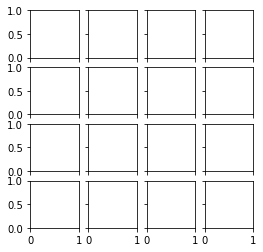

In [ ]:
# 하이퍼파라미터 설정
iterations = 5000
batch_size = 128
sample_interval = 1000 # 1000에폭에 저장해라

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

In [ ]:
z = np.random.normal(0, 1, (1, 1))

In [ ]:
# 랜덤한 잡음에서 이미지 생성하기
gen_imgs = generator.predict(z)

# 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
gen_imgs = 0.5 * gen_imgs + 0.5

1/1 [==============================] - 0s 13ms/step


In [ ]:
print(gen_imgs)

[[0.6196526 0.9551643 0.5604452 0.9335916 0.9061987 0.9816153]]
